# Isolating the soccer field 

> Decreasing the AOI : Area of Interest

> __This notebook needs a dataset to work, which contains videos__<br/>
> Use __Jupyter Lab__, makes the header files collapsible, much better working experience for large notebooks


## Pipelines

### Pipeline 1 `P_IF_1` -> __`methods.P_IF_1`__

Simple __Vanilla CV__ method for separating green fields. 

```
Pipeline Description 
1. Blur 
2. HSV Filtering 
3. Hue based masking (filtering)
```  
> Works well for given dataset but for some more varied dataset with less color differential between the crowd and the field, would require some pre-processing (increasing the dynamic range//decreasing the filter sens window)

-------

### Pipeline 2 `P_IF_2` -> __`methods.P_IF_2`__

A bit more advanced method using __vanilla CV__ based on color reduction
``` Pipeline 
1. Blur
2. HSV Filtering 
3. Quantization
3. Hue based masking (filtering)

```


> Works better in cases of overcast, 
  
-------
### Pipeline 3 `P_IF_3` -> __`methods.P_IF_3`__
Based on pixelation as the first filtering step. 
``` Pipeline 
1. Pixelation 
2. Contrast Reduction 
3. Blur 
4. Hue based masking 

```

--------------
### Pipeline 4 `P_IF_4` -> __`methods.P_IF_4`__
Experimental : Inpainting a small circle based on output of SobelXY -> Essentially removing all small deviations 



    
    

# Imports 

In [1]:
import sys  
import os
from pathlib import Path
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

# Set Root Directory
root = Path('/Users/flipflops/engineer/soccerEye')
sys.path.insert(0, str(root))

import utils
import methods

from IPython.display import Video
import cv2




In [2]:
# Set Dataset Path
dataset = Path('../dataset/dfl-bl/')
dataset = dataset.resolve()
print(f'Dataset Location : {dataset}')
dataset_files = utils.util_searching_all_files(dataset)[0]
print(f'Number of files in dataset : {len(dataset_files)}')

Dataset Location : /Users/flipflops/engineer/soccerEye/dataset/dfl-bl
Number of files in dataset : 50


# PIPELINE 1 

## Testing on one frame from a random video pick 

### Picking a test image

Video Picked (index) : 18
Total Frames in Video: 750.0


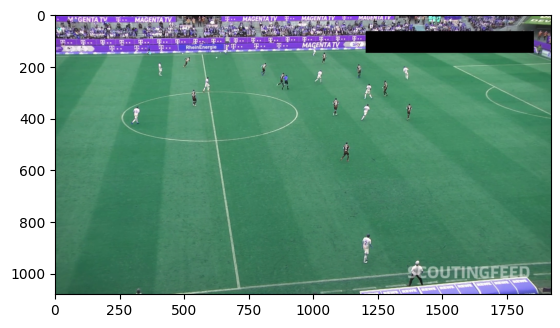

In [3]:
# Picking a Random Video

videoPick = np.random.randint(len(dataset_files))
print(f'Video Picked (index) : {videoPick}')

cap = cv2.VideoCapture(str(dataset_files[videoPick]))

# Picking a Random Frame From Video 

total_frames = cap.get(7)
print(f'Total Frames in Video: {total_frames}')

framePick = np.random.randint(total_frames)

# Display Random Frame 
if framePick < int(total_frames):
    cap.set(1, framePick)
    ret, frame = cap.read()
    imshow(frame)
else:
    print('Frame Number selected larger than max frame')

### Gaussian Blur 

In [4]:
# Blurring at 3 kernel sizes
kernelSizes = [(3, 3), (9, 9), (15, 15),(50,50),(80,80)]
li_bl_fr = []
for (kX, kY) in kernelSizes:
    blurred = cv2.blur(frame, (kX, kY))
    li_bl_fr.append(blurred)


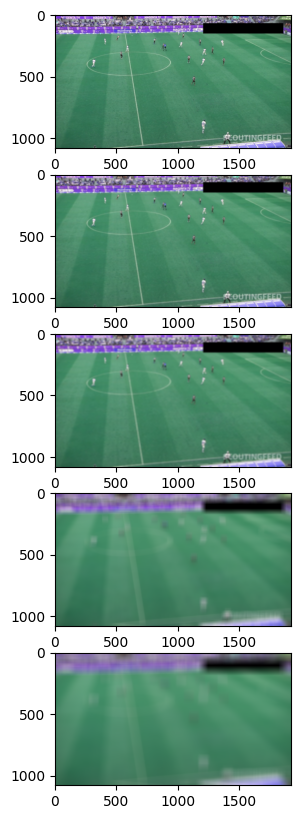

In [5]:
plt.rcParams['figure.figsize'] = [10, 10]

no_plots = len(li_bl_fr)

fig, axs = plt.subplots(no_plots)


for plotno in range(no_plots):
    axs[plotno].imshow(li_bl_fr[plotno])

### Masking

In [6]:
def green_mask(frame,hsv_sens=140):

    frame_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    lower_green = np.array([60 - hsv_sens, 100, 100])
    upper_green = np.array([60 + hsv_sens, 255, 255])

    mask = cv2.inRange(frame_hsv, lower_green, upper_green)
    return mask

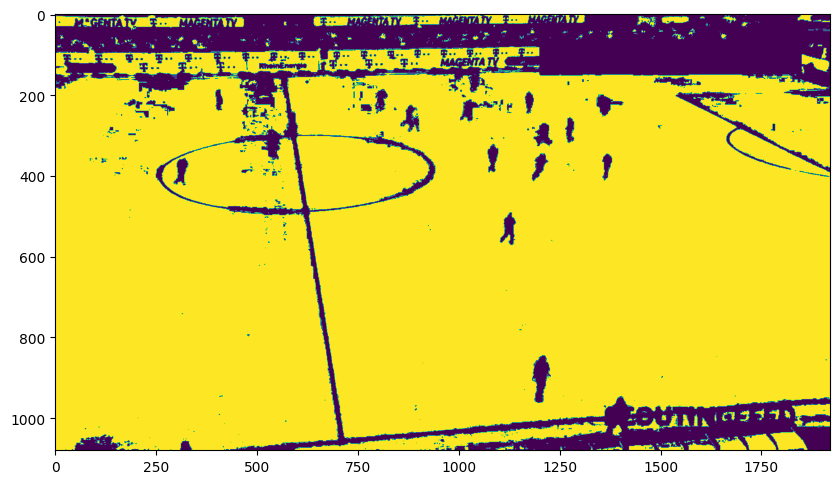

In [7]:
frame_masked = green_mask(frame)
imshow(frame_masked)

### Masking on Blurred Frames 

In [8]:
# Blurring at 3 kernel sizes
kernelSizes = [(3, 3), (9, 9), (15, 15),(50,50),(80,80)]
bl_fr_LI = []
for (kX, kY) in kernelSizes:
    blurred = cv2.blur(frame, (kX, kY))
    bl_fr_LI.append(blurred)
    

In [9]:
mk_bl_fr_LI = []
for blur_frame in bl_fr_LI:
    frame_masked = green_mask(blur_frame)
    mk_bl_fr_LI.append(frame_masked)

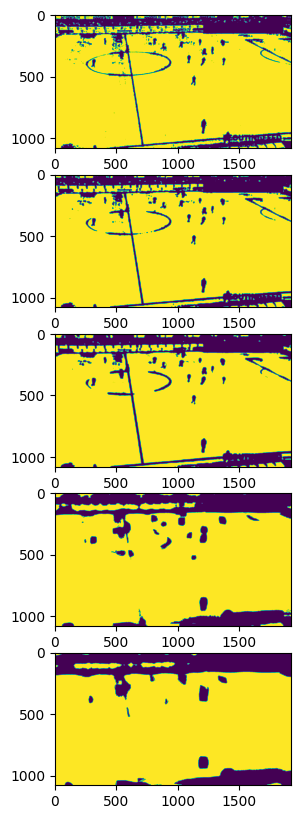

In [10]:
plt.rcParams['figure.figsize'] = [10, 10]

no_plots = len(mk_bl_fr_LI)
fig, axs = plt.subplots(no_plots)
for plotno in range(no_plots):
    axs[plotno].imshow(mk_bl_fr_LI[plotno])

### Creating the Final Pipeline `methods.P_IF_1`

In [11]:
def P_IF_1(frame,kernel_size=80,hsv_sens=140):
    # I = BGR 
    # O = Binary 
    
    blurred = cv2.blur(frame, (kernel_size, kernel_size))
    
    frame_hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)
    lower_green = np.array([60 - hsv_sens, 100, 100])
    upper_green = np.array([60 + hsv_sens, 255, 255])
    
    mask = cv2.inRange(frame_hsv, lower_green, upper_green)
    return mask
    

-------

# PIPELINE 2 

Video Picked (index) : 18
Total Frames in Video: 750.0


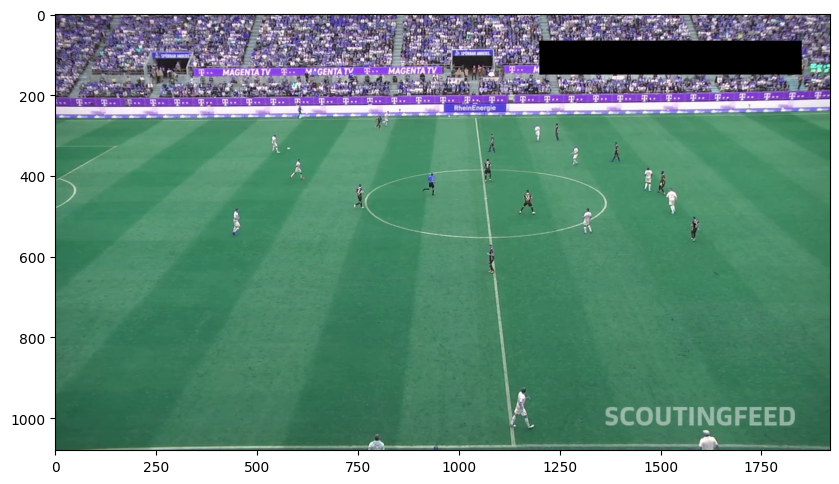

In [12]:
# Picking a Random Video

videoPick = np.random.randint(len(dataset_files))
print(f'Video Picked (index) : {videoPick}')

cap = cv2.VideoCapture(str(dataset_files[videoPick]))

# Picking a Random Frame From Video 

total_frames = cap.get(7)
print(f'Total Frames in Video: {total_frames}')

framePick = np.random.randint(total_frames)

# Display Random Frame 
if framePick < int(total_frames):
    cap.set(1, framePick)
    ret, frame = cap.read()
    imshow(frame)
else:
    print('Frame Number selected larger than max frame')

### Building the pipeline method

In [13]:

from methods import colorQuantize
def P_IF_2(frame,kernel_size=80,hsv_sens=140,quant=100):
    # I = BGR 
    # O = Binary 
    
    blurred = cv2.blur(frame, (kernel_size, kernel_size))
    frame_hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

    lower_green = np.array([60 - hsv_sens, 100, 100])
    upper_green = np.array([60 + hsv_sens, 255, 255])
    
    frame_hsv = colorQuantize(frame_hsv,div=quant)
    
    mask = cv2.inRange(frame_hsv, lower_green, upper_green)
    return mask
    

### Testing

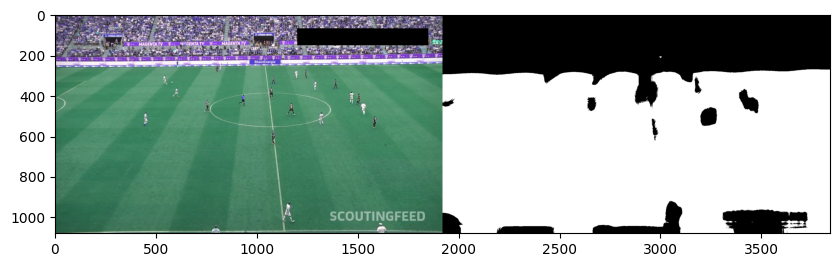

In [14]:
imshow(utils.stackImages([frame,methods.P_IF_2(frame)]))

# Random Experiments

Video Picked (index) : 23
Total Frames in Video: 750.0


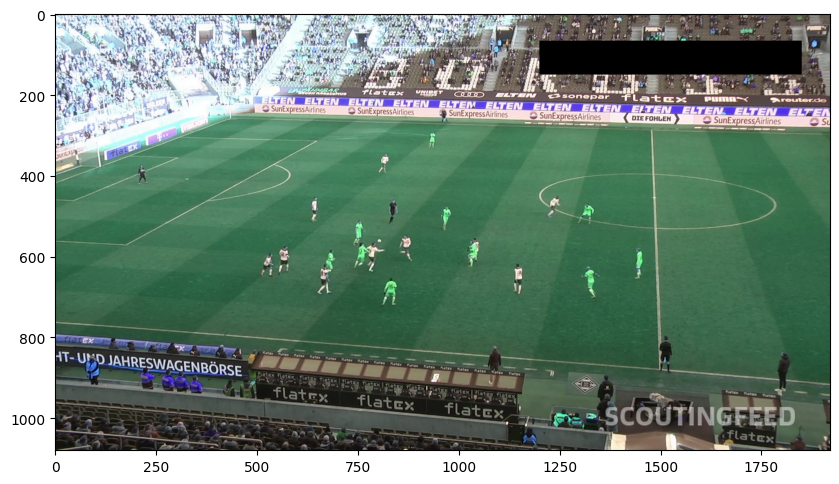

In [15]:
# Picking a Random Video

videoPick = np.random.randint(len(dataset_files))
print(f'Video Picked (index) : {videoPick}')

cap = cv2.VideoCapture(str(dataset_files[videoPick]))

# Picking a Random Frame From Video 

total_frames = cap.get(7)
print(f'Total Frames in Video: {total_frames}')

framePick = np.random.randint(total_frames)

# Display Random Frame 
if framePick < int(total_frames):
    cap.set(1, framePick)
    ret, frame = cap.read()
    imshow(frame)
else:
    print('Frame Number selected larger than max frame')

In [16]:
frame_g = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

#### Sobel -> Blurring Threshold

In [17]:
import matplotlib.pyplot as plt
from skimage import data, filters

In [18]:
image = frame.copy()
blurred_img = cv2.GaussianBlur(image, (11, 11), 0)
mask = np.zeros(image.shape, np.uint8)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)[1]
contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(mask, contours, -1, (255,255,255),5)
output = np.where(mask==np.array([100, 100, 100]), blurred_img, image)


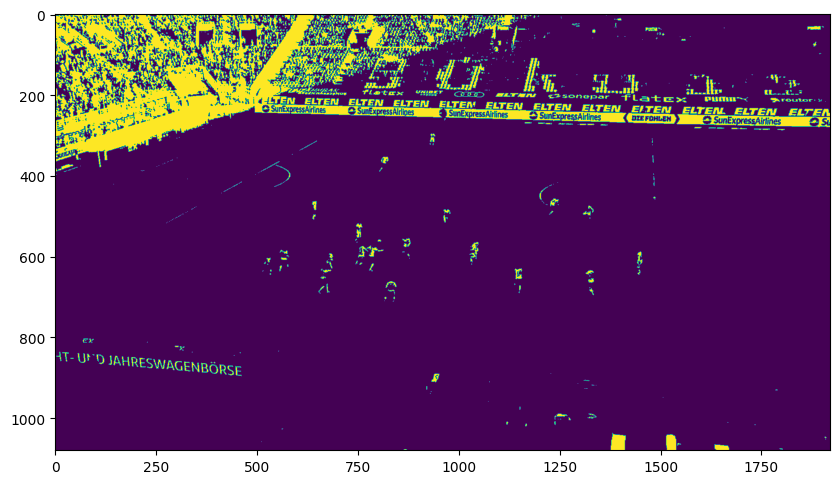

In [19]:
imshow(thresh)

#### Entropy Reduction ?

In [20]:
from skimage.filters.rank import entropy
from skimage.morphology import disk

In [21]:
entr_img = entropy(frame_g, disk(10))

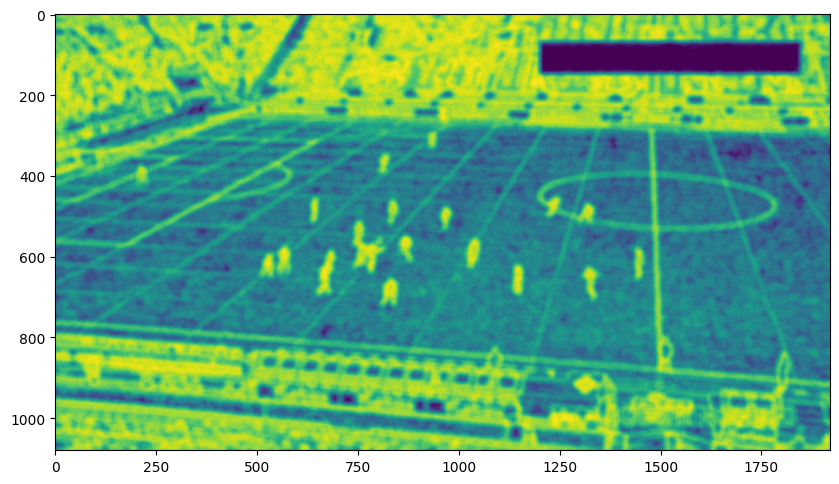

In [22]:
imshow(entr_img)

#### 

In [23]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, img_as_float,img_as_ubyte
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise


In [24]:
# astro = img_as_float(frame)
# sigma = 0.08
# noisy = random_noise(astro, var=sigma**2)

# # estimate the noise standard deviation from the noisy image
# sigma_est = np.mean(estimate_sigma(noisy, channel_axis=-1))
# print(f'estimated noise standard deviation = {sigma_est}')

# patch_kw = dict(patch_size=5,      # 5x5 patches
#                 patch_distance=6,  # 13x13 search area
#                 channel_axis=-1)

# # slow algorithm
# denoise = denoise_nl_means(noisy, h=1.15 * sigma_est, fast_mode=False,
#                            **patch_kw)

# # slow algorithm, sigma provided
# denoise2 = denoise_nl_means(noisy, h=0.8 * sigma_est, sigma=sigma_est,
#                             fast_mode=False, **patch_kw)

# # fast algorithm
# denoise_fast = denoise_nl_means(noisy, h=0.8 * sigma_est, fast_mode=True,
#                                 **patch_kw)

# # fast algorithm, sigma provided
# denoise2_fast = denoise_nl_means(noisy, h=0.6 * sigma_est, sigma=sigma_est,
#                                  fast_mode=True, **patch_kw)

# fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(8, 6),
#                        sharex=True, sharey=True)

# ax[0, 0].imshow(noisy)
# ax[0, 0].axis('off')
# ax[0, 0].set_title('noisy')
# ax[0, 1].imshow(denoise)
# ax[0, 1].axis('off')
# ax[0, 1].set_title('non-local means\n(slow)')
# ax[0, 2].imshow(denoise2)
# ax[0, 2].axis('off')
# ax[0, 2].set_title('non-local means\n(slow, using $\\sigma_{est}$)')
# ax[1, 0].imshow(astro)
# ax[1, 0].axis('off')
# ax[1, 0].set_title('original\n(noise free)')
# ax[1, 1].imshow(denoise_fast)
# ax[1, 1].axis('off')
# ax[1, 1].set_title('non-local means\n(fast)')
# ax[1, 2].imshow(denoise2_fast)
# ax[1, 2].axis('off')
# ax[1, 2].set_title('non-local means\n(fast, using $\\sigma_{est}$)')

# fig.tight_layout()

# # print PSNR metric for each case
# psnr_noisy = peak_signal_noise_ratio(astro, noisy)
# psnr = peak_signal_noise_ratio(astro, denoise)
# psnr2 = peak_signal_noise_ratio(astro, denoise2)
# psnr_fast = peak_signal_noise_ratio(astro, denoise_fast)
# psnr2_fast = peak_signal_noise_ratio(astro, denoise2_fast)

# print(f'PSNR (noisy) = {psnr_noisy:0.2f}')
# print(f'PSNR (slow) = {psnr:0.2f}')
# print(f'PSNR (slow, using sigma) = {psnr2:0.2f}')
# print(f'PSNR (fast) = {psnr_fast:0.2f}')
# print(f'PSNR (fast, using sigma) = {psnr2_fast:0.2f}')

# plt.show()

#### Pixelation

In [25]:
pixelated = image[::50, ::50]

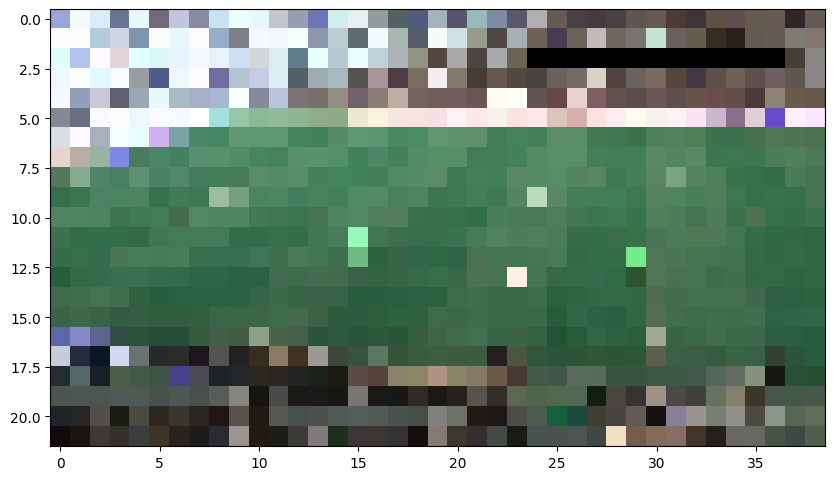

In [26]:
imshow(pixelated)

# PIPELINE 3 

Video Picked (index) : 25
Total Frames in Video: 750.0


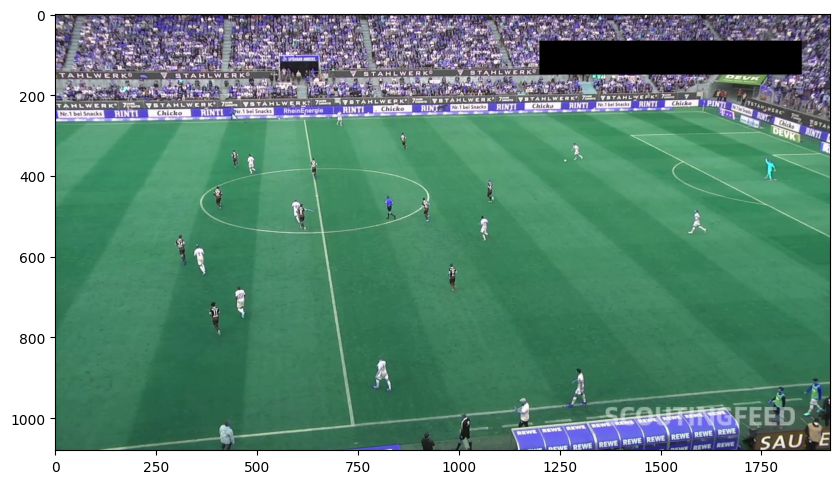

In [27]:
# Picking a Random Video

videoPick = np.random.randint(len(dataset_files))
print(f'Video Picked (index) : {videoPick}')

cap = cv2.VideoCapture(str(dataset_files[videoPick]))

# Picking a Random Frame From Video 

total_frames = cap.get(7)
print(f'Total Frames in Video: {total_frames}')

framePick = np.random.randint(total_frames)

# Display Random Frame 
if framePick < int(total_frames):
    cap.set(1, framePick)
    ret, frame = cap.read()
    imshow(frame)
else:
    print('Frame Number selected larger than max frame')

In [28]:
from skimage import exposure
from skimage import data, img_as_float,img_as_ubyte


def P_IF_3(frame,kernel_size=80,hsv_sens=20,pix_size=90):
    # I = BGR 
    # O = Binary 
    
    
    blurred = cv2.blur(frame, (kernel_size, kernel_size))
    
    
    # Desired "pixelated" size
    w, h = (pix_size, pix_size)
    height, width = blurred.shape[:2]
    # Resize input to "pixelated" size
    temp = cv2.resize(blurred, (w, h), interpolation=cv2.INTER_LINEAR)
    # Initialize output image
    frame_pixelated = cv2.resize(temp, (width, height), interpolation=cv2.INTER_NEAREST)
    # Equalization
    img_eq = img_as_ubyte(exposure.equalize_hist(frame_pixelated))
    # img_adapteq = exposure.equalize_adapthist(frame_pixelated, clip_limit=0.03)
    
    frame_hsv = cv2.cvtColor(img_eq, cv2.COLOR_BGR2HSV)
    

    lower_green = np.array([60 - hsv_sens, 40, 40])
    upper_green = np.array([60 + hsv_sens, 255, 255])
    mask = cv2.inRange(frame_hsv, lower_green, upper_green)
    return mask
    

/usr/local/Caskroom/miniconda/base/envs/se/lib/python3.8/site-packages/skimage/_shared/utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


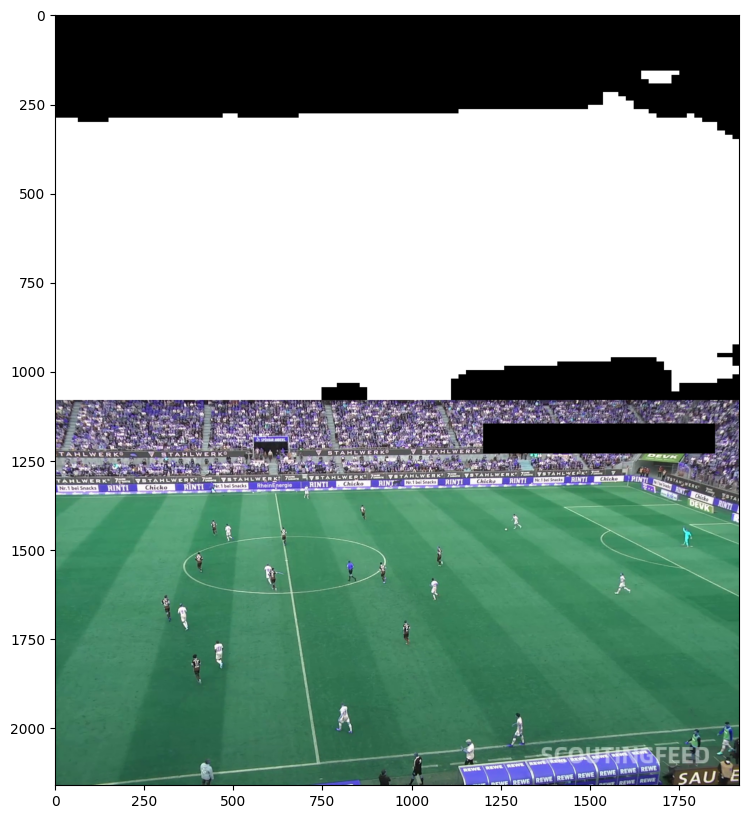

In [29]:
imshow(utils.stackImages([methods.P_IF_3(frame),
                         frame],axis=0))

In [30]:
videoPick = np.random.randint(len(dataset_files))
print(f'Video Picked (index) : {videoPick}')
cap = cv2.VideoCapture(str(dataset_files[videoPick]))

Video Picked (index) : 40


In [31]:
utils.applyToVideo(methods.P_IF_3,cap,skip=20,stack_original=True)

100%|█████████████████████████████████████████████████████████████████████████| 38/38 [00:22<00:00,  1.69it/s]


In [32]:
from tqdm import tqdm

In [33]:
methods.P_IF_3(frame).shape[1]

1920

In [34]:
frame.shape[2]

3

# References 
- [PIS Blurring](https://pyimagesearch.com/2021/04/28/opencv-smoothing-and-blurring/)